# MINT Onsite Demo
###### By Arthur Qin

The following notebook exemplifies how to use the offline version of MINT on the MC_Maze dataset, as well as what it is/what it offers.

References:
- [DANDI Dataset (MC Maze)](https://dandiarchive.org/dandiset/000128/0.220113.0400)
- [An emerging view of neural geometry in motor cortex supports high-performance decoding (Model Paper)](https://elifesciences.org/articles/89421)

### Overview
###### By Chad Boulay i think
Over simplified description: trials are grouped based on their behaviour, then combined to yield an idealized trajectory in neural space for that particular behaviour. During inference, one can find which neural trajectory is closest to the current neural state and then transform back into the behavior associated with that trajectory.

This algorithm can be trained quickly and can run inference quickly. However, it has a major drawback. First, because it builds a number of 'idealized' trajectories and those trajectories are from aggregates of similar behavioral epochs, it requires that the training data comprise epochs with repeated behaviors, forcing the interface developer to choose a calibration routine that selects a limited subset of possible behaviors. This works reasonably well for a center-out task with 4-8 directions and 1-3 distance. For continuous movement (e.g., random target grid task), the calibration data must be clustered by similar-enough behaviour, forcing the designer to make assumptions about what features of behaviour are represented smoothly in neural state space.

### Task

MINT is originally in MATLAB - three years ago, a Python port was made, but it was pretty much a 1:1 translation and extremely hard to work with. This new refactoring attempts to implement MINT in Python to be compatible with the ezmsg armada of decoders we are making for our benchmarking suite in our quest to find the biggest and baddest decoder of all. 


We start by loading in data from the downloads directory. See README for setup details.

In [1]:
import os
import time
import numpy as np
from pathlib import Path
from typing import List, Optional, Tuple
from sklearn.model_selection import train_test_split


from brn.mint.decoder import MINTDecoder, MINTSettings
from brn.mint.utils import process_kinematics, bin_data
from brn.mint.generic_config import generic_config

In [2]:
#Requires DANDI Dataset folder "000128" to be in Downloads directory
def get_trial_data(settings: dict, split: str = "train", n_trials: int | None = 50) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Helper function to get trial data from the MC Maze dataset.

    :param settings: dict with key "trialAlignment" which is a list of integers representing the indices
      for each trial relative to its move_onset_time.
    :param split: "train" or "test"
    :param n_trials: Number of trials to return, if None, returns all trials
    :return: S, Z, condition
        S: ndarray of shape (n_trials, n_neurons, n_time_steps), dtype bool with 1 at spike time, 0 otherwise . #np.uint64(50321)
        Z: ndarray of shape (n_trials, 4 (pos_x, pos_y, vel_x, vel_y), n_time_steps), dtype float
        condition: ndarray of shape (n_trials,), dtype int with condition indices
    """
    datadir = os.getenv("MC_MAZE_DATASET_PATH", str(Path.home() / "Downloads" / "000128"))
    train_path = Path(datadir) / "sub-Jenkins" / "sub-Jenkins_ses-full_desc-train_behavior+ecephys.nwb"
    test_path = Path(datadir) / "sub-Jenkins" / "sub-Jenkins_ses-full_desc-test_ecephys.nwb"

    # Load dataset
    import pynwb
    with pynwb.NWBHDF5IO(test_path if split == "test" else train_path, "r") as io:
        read_nwbfile = io.read()
        # metadata fields: devices, electrode_groups, electrodes, session_description, subject, etc.

        # Find the trial info and keep only the subset we want
        trial_info = read_nwbfile.intervals["trials"].to_dataframe()
        trial_info = trial_info[trial_info["split"] == split]

        n_trials = n_trials or len(trial_info)

        # Find unique conditions
        if split == "test":
            condition = -1 * np.ones(n_trials, dtype=int)
        else:
            conds = trial_info.set_index(["trial_type", "trial_version"]).index.tolist()
            cond_list = trial_info.set_index(["trial_type", "trial_version"]).index.unique().tolist()
            cond_list.sort()
            condition = np.array([cond_list.index(_) + 1 for _ in conds[:n_trials]])

        # Get a timestamp vector for all behavior data
        behav_dict = read_nwbfile.processing["behavior"].data_interfaces
        assert np.array_equal(behav_dict["hand_pos"].timestamps[:], behav_dict["hand_vel"].timestamps[:])
        all_ts = behav_dict["hand_pos"].timestamps[:]

        # Find the index where each trial's move period starts
        trial_onsets_beh = np.searchsorted(all_ts, trial_info[:n_trials]["move_onset_time"])

        # Take per-trial data from position and velocity arrays.
        trial_inds = settings["trialAlignment"]
        all_trial_inds = trial_onsets_beh[:, None] + trial_inds[None, :]
        all_trial_ts = np.take(all_ts, all_trial_inds, axis=0)

        all_pos = np.take(behav_dict["hand_pos"].data, all_trial_inds, axis=0)
        all_vel = np.take(behav_dict["hand_vel"].data, all_trial_inds, axis=0)
        Z = np.concatenate((all_pos, all_vel), axis=-1)
        Z = np.transpose(Z, (0, 2, 1))  # Shape -> (n_trials, 4, n_steps)

        # Create a boolean array for spikes with the same shape for trials and times as the behaviour data.
        n_neurons = read_nwbfile.units["spike_times"].data.shape[0]
        n_steps = len(trial_inds)
        S = np.zeros((n_trials, n_neurons, n_steps), dtype=bool)
        # For each neuron, for each trial, find the spike times and set the corresponding indices to True
        for unit_ix in range(n_neurons):
            spike_times = read_nwbfile.units["spike_times"][unit_ix]
            for trial_ix, trial_tvec in enumerate(all_trial_ts):
                # Find the spike times that fall within the trial time vector
                trial_spike_times = spike_times[np.logical_and(spike_times >= trial_tvec[0], spike_times <= trial_tvec[-1])]
                spike_inds = np.searchsorted(trial_tvec, trial_spike_times)
                # Set the corresponding indices in S to True
                S[trial_ix, unit_ix, spike_inds] = True

    return S, Z, condition


def mc_maze_config(causal):
    # Get some generic settings and hyperparameters.
    [settings, hyper_params] = generic_config()

    # Determine which time period of raw data should be loaded on each trial,
    # relative to move onset. This should be broad enough to meet all the
    # training needs and provide necessary spiking history for testing.
    settings["trialAlignment"] = np.arange(-800, 901, 1)

    # Determine which time period should be used to evaluate performance,
    # relative to move onset.
    settings["testAlignment"] = np.arange(-250, 451, 1)

    # Hyperparameters related to learning neural trajectories.

    # Set where idealized neural trajectories will begin and end, relative to
    # move onset.
    hyper_params["trajectoriesAlignment"] = np.arange(-500, 701, 1)

    # When learning PSTHs, 'sigma' is the standard deviation of the Gaussian filter.
    hyper_params["sigma"] = 30

    # After learning PSTHs, one may wish to try to further improve the PSTHs.
    # Depending on the data set, it may be beneficial to reduce the
    # dimensionality of the PSTHs across neurons, across conditions, or across
    # trials within each condition. A value of NaN means don't reduce
    # dimensionality.
    hyper_params["nNeuralDims"] = np.nan
    hyper_params["nCondDims"] = 21
    hyper_params["nTrialDims"] = 1  # I typically only ever use NaN or 1

    # Hyperparameters related to inference.

    # What bin size to run inference at. Real-time estimates can still be
    # generated at a higher resolution than this - this value just determines
    # how frequently you update based on new spiking observations.
    hyper_params["Delta"] = 20
    if causal:
        hyper_params["obsWindow"] = 300
    else:
        hyper_params["obsWindow"] = 580

    # The 'causal' hyperparameter is a logical determining whether inference is
    # performed based on a trailing history of spikes (causal = true) or
    # inference is performed based on a spiking window centered around the
    # current time (causal = false).
    hyper_params["causal"] = causal

    return [settings, hyper_params]


# Loads in training and test data
[settings, hyper_params] = mc_maze_config(True)
S_all, Z_all, condition_all = get_trial_data(settings, split="train")


c:\Users\aqin\Documents\MINT\.venv\Lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.4.0, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


In [3]:
S_train, S_val, Z_train, Z_val, cond_train, cond_val = train_test_split(
    S_all, Z_all, condition_all,
    test_size=0.2, random_state=129
)

#### Initialize MINT

Here we initialize the settings module for MINT and create a decoder instance:

In [4]:

settings = MINTSettings(
    task='mc_maze', 
    data_path="C:/Users/aqin/Downloads/000128/sub-Jenkins/",
    results_path="C:/Users/aqin/Downloads/results",
    bin_size=20,
    observation_window=300,
    causal=True,
    trial_alignment=np.arange(-800, 901, 1),
    test_alignment=np.arange(-250, 451, 1),
    trajectories_alignment=np.arange(-500, 701, 1),
    gaussian_sigma=30,
    neural_dims=np.nan,
    condition_dims=21,
    trial_dims=1,
    min_lambda=1.0,
    sampling_period=0.001,
    soft_norm=5.0,
    min_prob=1e-6,
    min_rate=0.0,
    interp_mode=2,
    interp_max_iters=10,
    interp_tolerance=0.01,
    num_rate_bins=2000
)

decoder = MINTDecoder(settings)


### Training MINT

The following code trains MINT on training data loaded above. 

In [5]:
t0 = time.perf_counter()
decoder.fit(spikes=S_train, behavior=Z_train, cond_ids=cond_train)
fit_secs = time.perf_counter() - t0
print(f"Fitting took {fit_secs:.3f} s")

Fitting took 2.702 s


### Evaluating MINT

The following code evaluates the fitted decoder on test data, which was loaded above. All predicted estimates are saved in estimates dictionary, used for visualization below

Notes: 

1. Online prediction capability is still being added, as the original MATLAB model was offline only (and so is this notebook).

2. Prediction is currently slow, because the MATLAB code used a method to pre-compile data during its internal recursion that hasn't yet been replicated in Python. Work in progress.

In [6]:
#Post-predict function prediction stuff starts here
Z_val = process_kinematics(Z_val, decoder.settings.trial_alignment)
test_buffer = np.array((-decoder.settings.observation_window + 1, 0))
if not decoder.settings.causal:
    test_buffer = test_buffer + np.round(
        (decoder.settings.observation_window + decoder.settings.bin_size) / 2
    )

buff_align_start = decoder.settings.test_alignment[0] + test_buffer[0]
buff_align_end = decoder.settings.test_alignment[-1] + test_buffer[1]
buffered_alignment = np.arange(buff_align_start, buff_align_end + 1)
t_mask = np.isin(decoder.settings.trial_alignment, buffered_alignment)
S_val = S_val[:, :, t_mask]
Z_val = Z_val[:, :, t_mask]

t1 = time.perf_counter()
X_hat, Z_hat = decoder.predict(S_val)
pred_secs = time.perf_counter() - t1
print(f"Predict function took {pred_secs:.3f} s")

not_buff_mask = np.isin(buffered_alignment, decoder.settings.test_alignment)
Z_val = Z_val[..., not_buff_mask]
Z_hat = Z_hat[..., not_buff_mask]
X_hat = X_hat[..., not_buff_mask]

# Convert neural state estimate to spikes/second
X_hat /= (decoder.settings.bin_size * decoder.settings.sampling_period)

# Store estimates
# Note: previously each value was a list of arrays, now just an array.
estimates = {
    "Z": Z_val,
    "Z_hat": Z_hat,
    "X_hat": X_hat,
}

Predict function took 4.822 s


### Scoring/Visualization

The following code block visualizes MINT's behavioral predictions compared to the ground-truth behaviors. 

Note: MINT translation from MATLAB is still a work in progress. Interpolation, which is filling in gaps in MINT's prediction, is a little bit wonky which may make some predicted trajectories to look like a hungry creature took a couple bites out of them.


First, import matplotlib and define visualization functions:

In [7]:
import matplotlib.pyplot as plt

def _select_trials(
    estimates: dict,
    n_show: int,
    best: bool,
    eval_bin_size: int
) -> List[int]:
    """
    Returns best and worst trials by R^2 value. 
    """
    Z     = estimates['Z']       # (n_trials, 4, T)
    Z_hat = estimates['Z_hat']

    scores = []
    for i in range(len(Z)):
        # bin each trial
        true_b = bin_data(Z[i],     eval_bin_size, method='mean')
        pred_b = bin_data(Z_hat[i], eval_bin_size, method='mean')
        # hstack along time
        tcat = np.hstack([true_b])
        pcat = np.hstack([pred_b])
        # remove NaN columns
        mask = np.any(np.isnan(pcat), axis=0)
        t = tcat[:, ~mask]
        p = pcat[:, ~mask]
        # R2 per feature
        ss_res = np.sum((t - p)**2, axis=1)
        mu     = np.mean(t, axis=1, keepdims=True)
        ss_tot = np.sum((t - mu)**2, axis=1)
        r2     = 1 - ss_res/ss_tot
        scores.append(r2.mean())
    idx = np.argsort(scores)
    if best:
        return idx[-n_show:][::-1].tolist()
    else:
        return idx[:n_show].tolist()


def visualize_mint_predictions(
    estimates: dict,
    trial_indices: Optional[List[int]] = None,
    time_window: Optional[Tuple[int,int]] = None,
    bin_size: int    = 20,
    eval_bin_size: int = 20,
    best: Optional[bool] = True,
    n_show: int = 3
):
    """
    Shows MINT predictions of kinematic variables compared to ground truth.
    """
    behavior = estimates['Z']
    behavior_hat = estimates['Z_hat']
    

    # pick trials if needed
    if trial_indices is None and best is not None:
        trial_indices = _select_trials(estimates, n_show, best, eval_bin_size)
    elif trial_indices is None:
        trial_indices = list(range(min(n_show, len(behavior))))


    # Channel labels
    channel_labels = ['X Position', 'Y Position', 'X Velocity', 'Y Velocity']
    channel_units = ['(units)', '(units)', '(units/s)', '(units/s)']
    
    fig, axes = plt.subplots(2,2,figsize=(15,10))
    axes = axes.flatten()
    colors = plt.cm.Set1(np.linspace(0,1,len(trial_indices)))
    for ch in range(4):
        ax = axes[ch]
        for ti, c in zip(trial_indices, colors):
            true = behavior[ti][ch]
            pred = behavior_hat[ti][ch]
            if time_window is not None:
                s,e = time_window
                true = true[s:e]
                pred = pred[s:e]
            tvec = np.arange(len(true)) * bin_size
            ax.plot(tvec, true, '-',  color=c, linewidth=2, alpha=0.7,
                    label=f'True (Trial {ti})' if ch==0 else None)
            ax.plot(tvec, pred, '--', color=c, linewidth=2, alpha=0.9,
                    label=f'Pred (Trial {ti})' if ch==0 else None)
        ax.set_title(f'{channel_labels[ch]} {channel_units[ch]}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel(channel_labels[ch])
        ax.grid(True, alpha=0.3)
        
        # Add legend only to first subplot
        if ch==0:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.suptitle('MINT Decoder: True vs Predicted Cursor Kinematics', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.show()


def visualize_trajectory_2d(
    estimates: dict,
    trial_indices: Optional[List[int]] = None,
    time_window: Optional[Tuple[int,int]] = None,
    best: Optional[bool] = True,
    eval_bin_size: int = 20,
    n_show: int = 5
):
    """
    This function visualizes predicted vs true cursor trajectories.
    """
    behavior = estimates['Z']
    behavior_hat = estimates['Z_hat']
    

    if trial_indices is None and best is not None:
        trial_indices = _select_trials(estimates, n_show, best, eval_bin_size)
    elif trial_indices is None:
        trial_indices = list(range(min(n_show, len(behavior))))

    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,6))
    colors = plt.cm.viridis(np.linspace(0,1,len(trial_indices)))
    for ti, c in zip(trial_indices, colors):
        tx, ty = behavior[ti][0], behavior[ti][1]
        px, py = behavior_hat[ti][0], behavior_hat[ti][1]
        if time_window is not None:
            s,e = time_window
            tx, ty = tx[s:e], ty[s:e]
            px, py = px[s:e], py[s:e]
        ax1.plot(tx, ty, '-',  color=c, linewidth=2, alpha=0.8, label=f'Trial {ti}')
        ax1.scatter(tx[0],  ty[0],  s=50, marker='o', edgecolors='black')
        ax1.scatter(tx[-1], ty[-1], s=50, marker='s', edgecolors='black')
        ax2.plot(px, py, '--', color=c, linewidth=2, alpha=0.8)
        ax2.scatter(px[0],  py[0],  s=50, marker='o', edgecolors='black')
        ax2.scatter(px[-1], py[-1], s=50, marker='s', edgecolors='black')
    ax1.set_title('True Cursor Trajectories')
    ax1.set_xlabel('X Position'); ax1.set_ylabel('Y Position'); ax1.grid(True); ax1.legend()
    ax1.set_aspect('equal')
    ax2.set_title('Predicted Cursor Trajectories')
    ax2.set_xlabel('X Position'); ax2.set_ylabel('Y Position'); ax2.grid(True); ax2.legend()
    ax2.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle(f"2D Cursor Trajectories (trials={trial_indices})", y=1.02)
    plt.show()


def calculate_r2(y_true, y_pred):
    """Compute R² score between true and predicted arrays."""
    
    
    # Remove any time bins where decode is NaN
    nan_mask = np.any(np.isnan(y_pred), axis=0)
    y_true = y_true[:, ~nan_mask]
    y_pred = y_pred[:, ~nan_mask]

    # Residual sum of squares
    SS_res = np.sum((y_true - y_pred) ** 2, axis=1)

    # Total sum of squares
    mean_true = np.mean(y_true, axis=1, keepdims=True)
    SS_tot = np.sum((y_true - mean_true) ** 2, axis=1)

    # Coefficient of determination
    R2 = 1 - SS_res / SS_tot

    return R2


def plot_r2_summary(estimates, eval_bin_size=20):
    """
    Plot R² scores for each behavioral channel.
    """
    
    from brn.mint.utils import bin_data
    
    # Unpack data
    behavior = estimates['Z']
    behavior_estimate = estimates['Z_hat']
    
    # Bin each trial
    Z_binned = [bin_data(z, eval_bin_size, method='mean') for z in behavior]
    Z_hat_binned = [bin_data(zhat, eval_bin_size, method='mean') for zhat in behavior_estimate]
    
    # Concatenate trials
    Z_concat = np.hstack(Z_binned)
    Z_hat_concat = np.hstack(Z_hat_binned)
    
    # Calculate R² per feature
    R2 = calculate_r2(Z_concat, Z_hat_concat)
    
    # Create bar plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    channel_labels = ['X Position', 'Y Position', 'X Velocity', 'Y Velocity']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    bars = ax.bar(channel_labels, R2, color=colors, alpha=0.7, edgecolor='black')
    
    # Add value labels on bars
    for bar, r2_val in zip(bars, R2):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{r2_val:.3f}', ha='center', va='bottom', fontweight='bold')
    
    ax.set_ylabel('R² Score', fontsize=12)
    ax.set_title('MINT Decoder Performance by Channel', fontsize=14, fontweight='bold')
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add average R² line
    avg_r2 = np.mean(R2)
    ax.axhline(y=avg_r2, color='red', linestyle='--', linewidth=2, 
               label=f'Average R² = {avg_r2:.3f}')
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    return R2


def visualize_scatter_comparison(estimates, start_time_ms=200, subsample_factor=10):
    """
    Scatter plots comparing true vs predicted values.
    """
    
    behavior = estimates['Z']
    behavior_estimate = estimates['Z_hat']
    
    start_idx = start_time_ms
    
    # Collect all data points
    all_true = []
    all_pred = []
    
    for trial_idx in range(len(behavior)):
        true_data = behavior[trial_idx][:, start_idx:]
        pred_data = behavior_estimate[trial_idx][:, start_idx:]
        
        all_true.append(true_data)
        all_pred.append(pred_data)
    
    # Stack and subsample for scatter plot
    true_concat = np.hstack(all_true)  # (4, all_timepoints)
    pred_concat = np.hstack(all_pred)
    
    # Subsample for visualization
    n_points = true_concat.shape[1]
    indices = np.arange(0, n_points, subsample_factor)
    
    channel_labels = ['X Position', 'Y Position', 'X Velocity', 'Y Velocity']
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    for ch_idx in range(4):
        ax = axes[ch_idx]
        
        true_vals = true_concat[ch_idx, indices]
        pred_vals = pred_concat[ch_idx, indices]
        
        # Remove any NaN values
        valid_mask = ~(np.isnan(true_vals) | np.isnan(pred_vals))
        true_vals = true_vals[valid_mask]
        pred_vals = pred_vals[valid_mask]
        
        # Scatter plot
        ax.scatter(true_vals, pred_vals, alpha=0.5, s=1)
        
        # Unity line
        min_val = min(np.min(true_vals), np.min(pred_vals))
        max_val = max(np.max(true_vals), np.max(pred_vals))
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, alpha=0.8)
        
        # Calculate R²
        r2 = calculate_r2(true_vals.reshape(1, -1), pred_vals.reshape(1, -1))[0]
        
        ax.set_title(f'{channel_labels[ch_idx]} (R²={r2:.3f})', fontsize=12, fontweight='bold')
        ax.set_xlabel('True Values')
        ax.set_ylabel('Predicted Values')
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal', adjustable='box')
    
    plt.tight_layout()
    plt.suptitle('True vs Predicted Scatter Plots', fontsize=14, fontweight='bold', y=1.02)
    plt.show()

#### Show R2 Performance

The next code block shows R squared performance of the Python MINT decoder both per-kinematic label and averaged. 

Here is MINT's performance on MC_Maze and other datasets from the original paper.
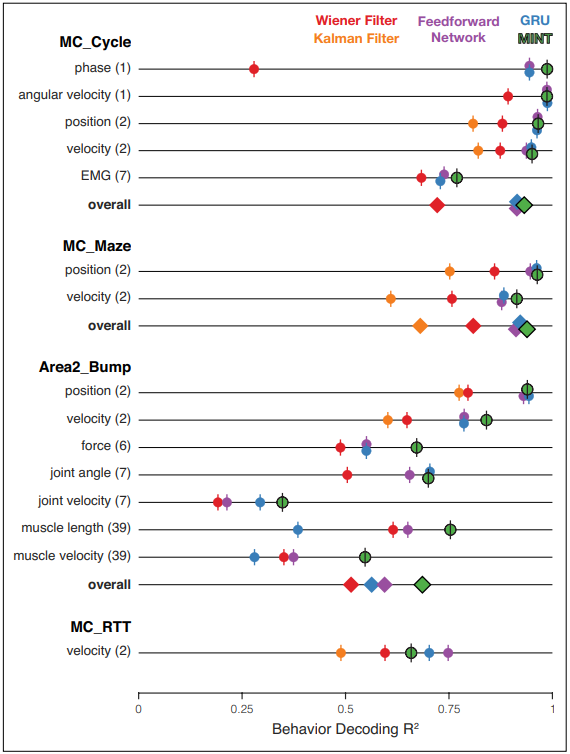

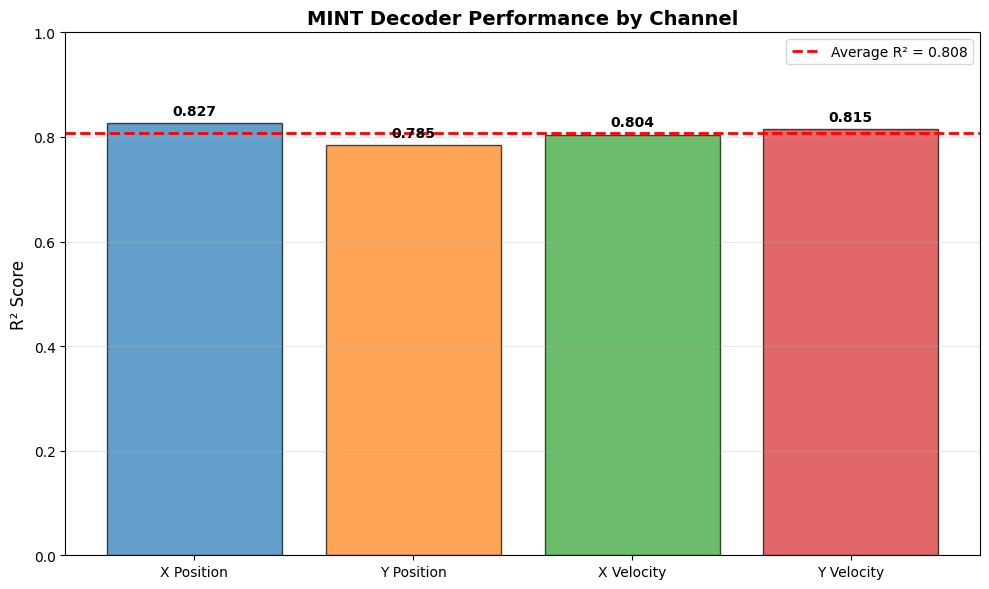

In [8]:
r2_scores = plot_r2_summary(estimates)

#### Per-trial Output Visualization

There are three ways to visualize MINT's predictions per-trial:

1. Use specific trial indices. Delete the ```best``` parameter and add/modify ```trial_indices``` with the specific trial indexes you want to be displayed. Example: ```visualize_mint_predictions(estimates, trial_indices=[0, 5, 11, 26, 30])```.

2. Show best trials. Delete ```trial_indices``` and instead pass in ```best=True```. If you want to increase the number of sorted trials shown, specify with ```n_show=```  (default 3). Example: ```visualize_mint_predictions(estimates, best=True, n_show=5)```.

3. Show worst trials (results may be scary). Same as above, just set ```best``` to ```False```. 

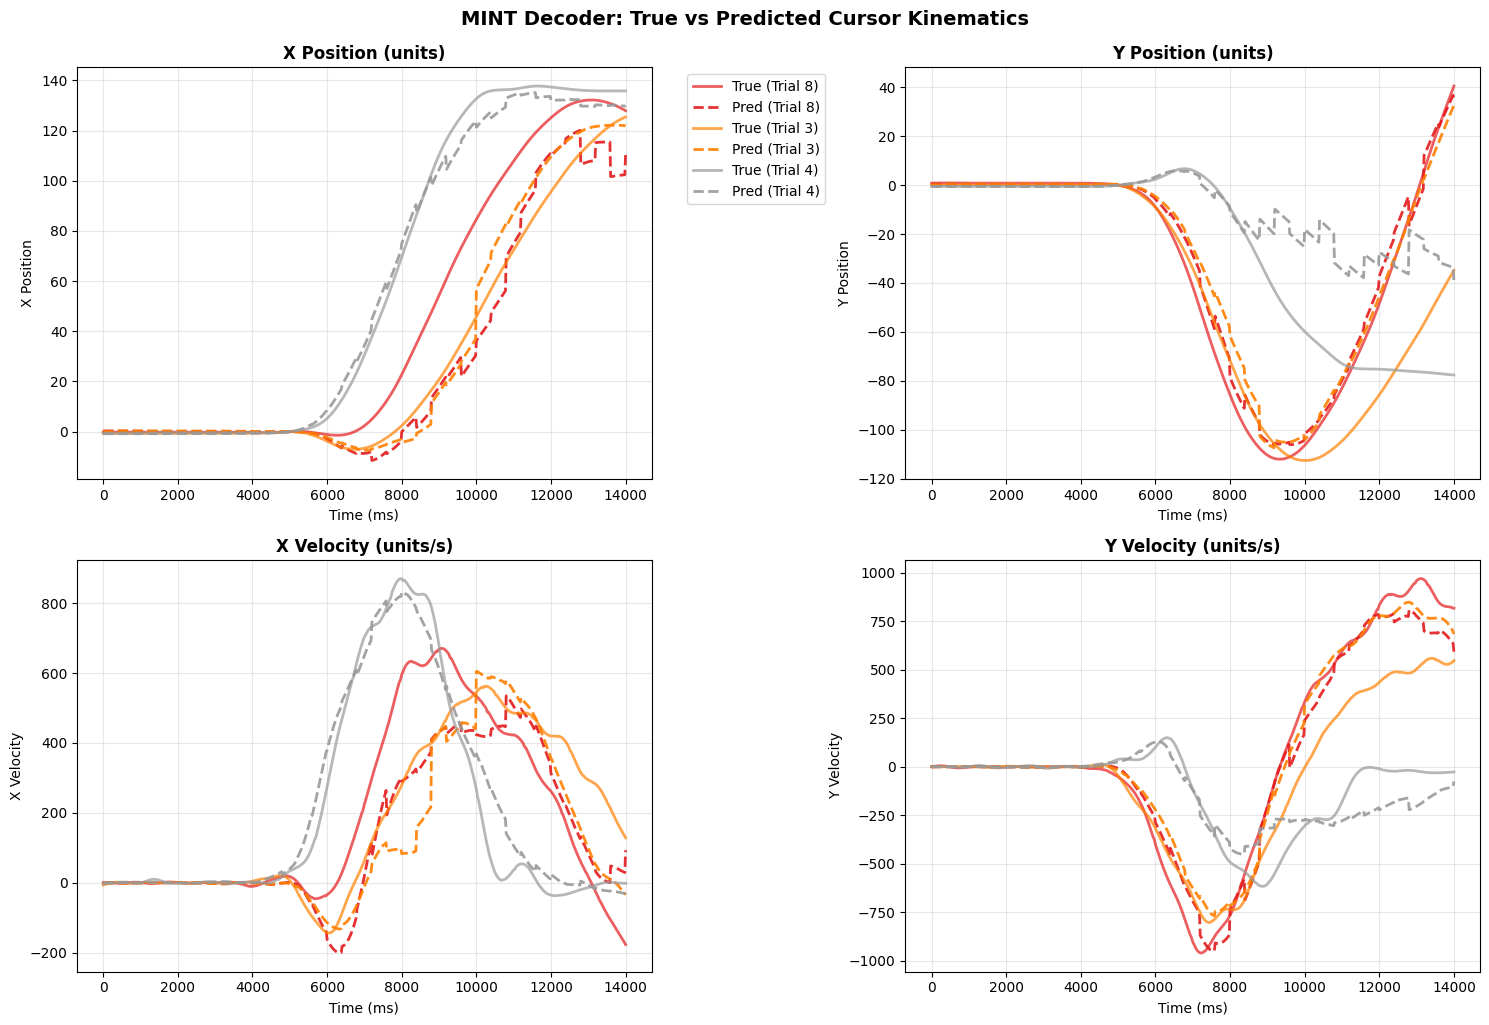

In [9]:
visualize_mint_predictions(estimates, best=True)

#### Cursor Trajectory Output Visualization

The same three ways from above apply here. This shows predicted cursor trajectories compared to their true counterparts.

1. Use specific trial indices. Modify ```trial_indices``` with the specific trial indexes you want to be displayed.

2. Show best trials. Delete ```trial_indices``` and instead pass in ```best=True```. If you want to increase the number of sorted trials shown, specify with ```n_show=```  (default 5).

3. Show worst trials. Set ```best``` to ```False```. 

C:\Users\aqin\AppData\Local\Temp\ipykernel_29036\1806241421.py:137: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.set_xlabel('X Position'); ax2.set_ylabel('Y Position'); ax2.grid(True); ax2.legend()


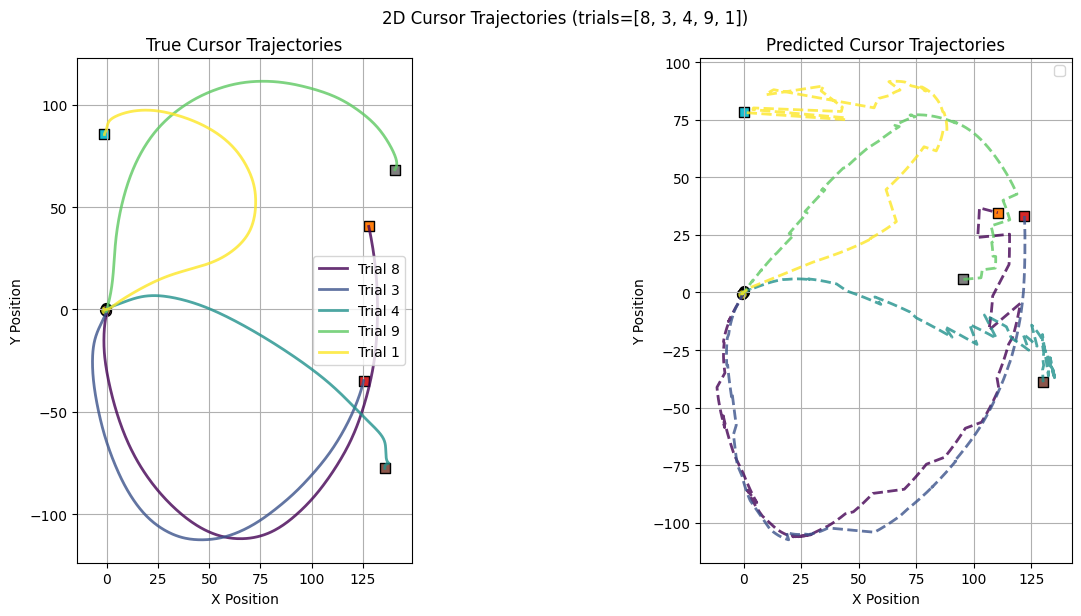

In [10]:
visualize_trajectory_2d(estimates, best=True)

#### Scatter Plot of True vs. Predicted Behavior

To better showcase the predicted R squared values of the model and its general prediction trends, below are scatter plots for each kinematic variable in predicted behavior. 

To change how many dots are displayed, add and modify the ```subsample_factor``` parameter to the below function call to have an integer. Default value is 10, which means 1 in every 10 predictions are plotted. A value of 20 would mean 1 in 20 are plotted, and a value of 1 would mean every single prediction is plotted.

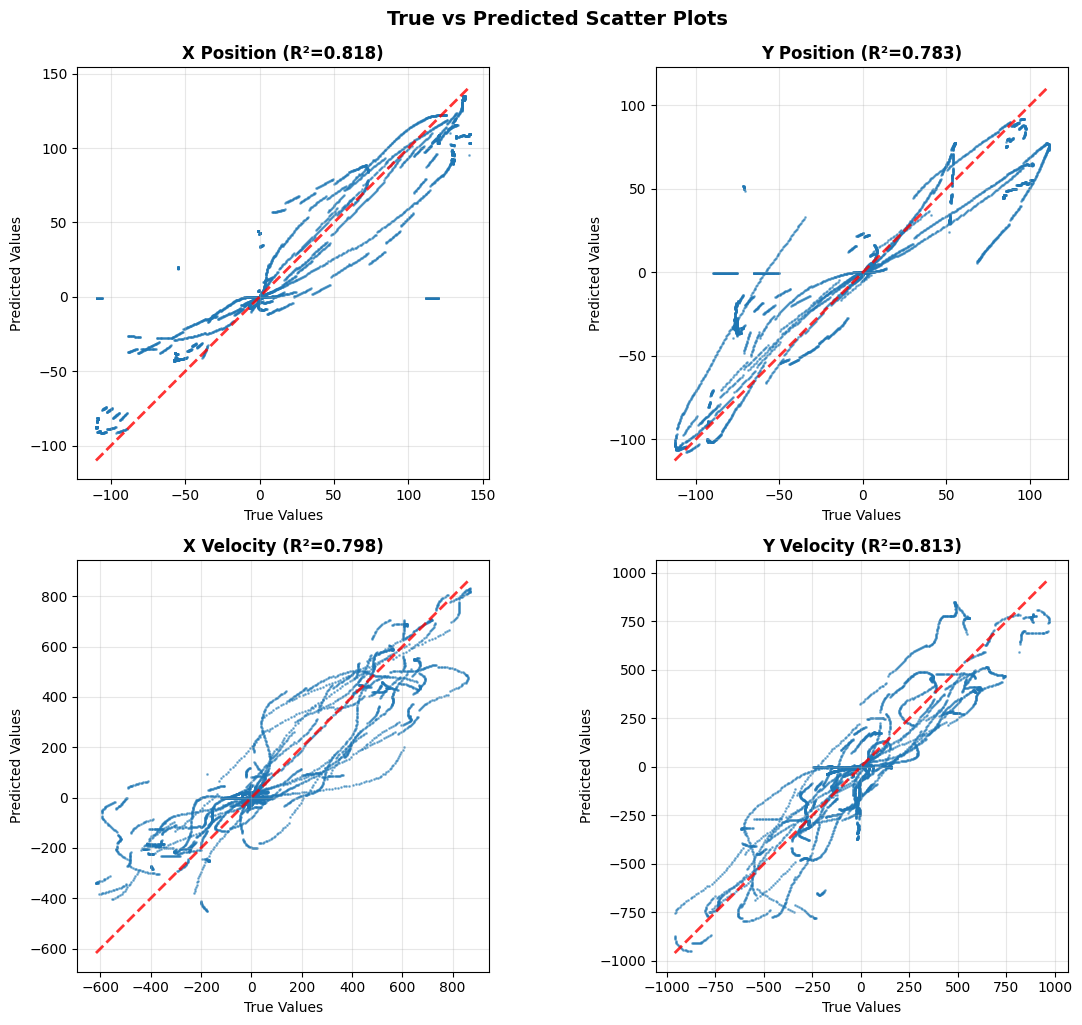

In [12]:
visualize_scatter_comparison(estimates, start_time_ms=200, subsample_factor=1)